# 2-layer NN for stellar classification

In many areas of data-science and ML, a typical problem that arises is how to classify data.

Imagine some set of images of furniture. In these images, you (a human) may easily detect different types of furniture: chairs, tables, desks, and even some beds. These are all easily distinguishable because YOU know what a table or a chair is. However, imagine these sets of images were given to a child or an alien. Without prior knowledge of what a chair or table is, it would be pretty tricky to classify a given image into one category or another. 

One possible way of explaining (to this curious alien) how to go about classifying furniture would be to describe what you see in the image (e.g., if it has four legs and a back rest, it is likely a chair). In describing the image, you are fixating on the ``features'' or the properties of the image. 

Now imagine that instead of classifying furniture you are trying to discern from stellar observations if a star is a red giant or a dwarf. The problem here is the same: you have a set of inputs (stars) with some features (magnitudes, temperatures, etc...) that describe the properties of the star, and you want to classify the inputs into different categories based on these features (i.e., you want to discern if you have chairs or tables in your images of furniture based on the features in your image). How would you tell the alien to do this if you don't have a deep understanding of stellar structure?

Well, this is where machine-learning can help. A possible solution to the problem mentioned above involves building a machine-learning model able to predict stellar types based on stellar properties. This is what we will do in this post. We will use a 2-layer neural-network (NN) to predict the type of star in the GALAH DR3 data set based on some stellar properties.


In [4]:
# import the necessary libraries
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import daft
import pandas as pd
import jax
import tqdm
import cmasher as cm
from keras.utils import to_categorical

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

# What is a neural-network?

In short, a NN is a machine-learning model that connects some input labels (data) with some neurons (hence the name) in some layer via some parameters known as weights and biases, which in turn are connected to some output (prediction). The number of neurons and layers is arbitrary, and in essense serve as a transformation of the input data into the model prediction.  

Each layer is connected to the previous and subsequent one, and every neuron i a given layer is connected to every other neuron in the adjacent layers. As you can imagine, connecting all the neurons across the layers can quickly complicate things. This is what makes NNs so powerful.

Below is an example of a 2-layer NN architecture, shown using the $\textbf{daft}$ package.


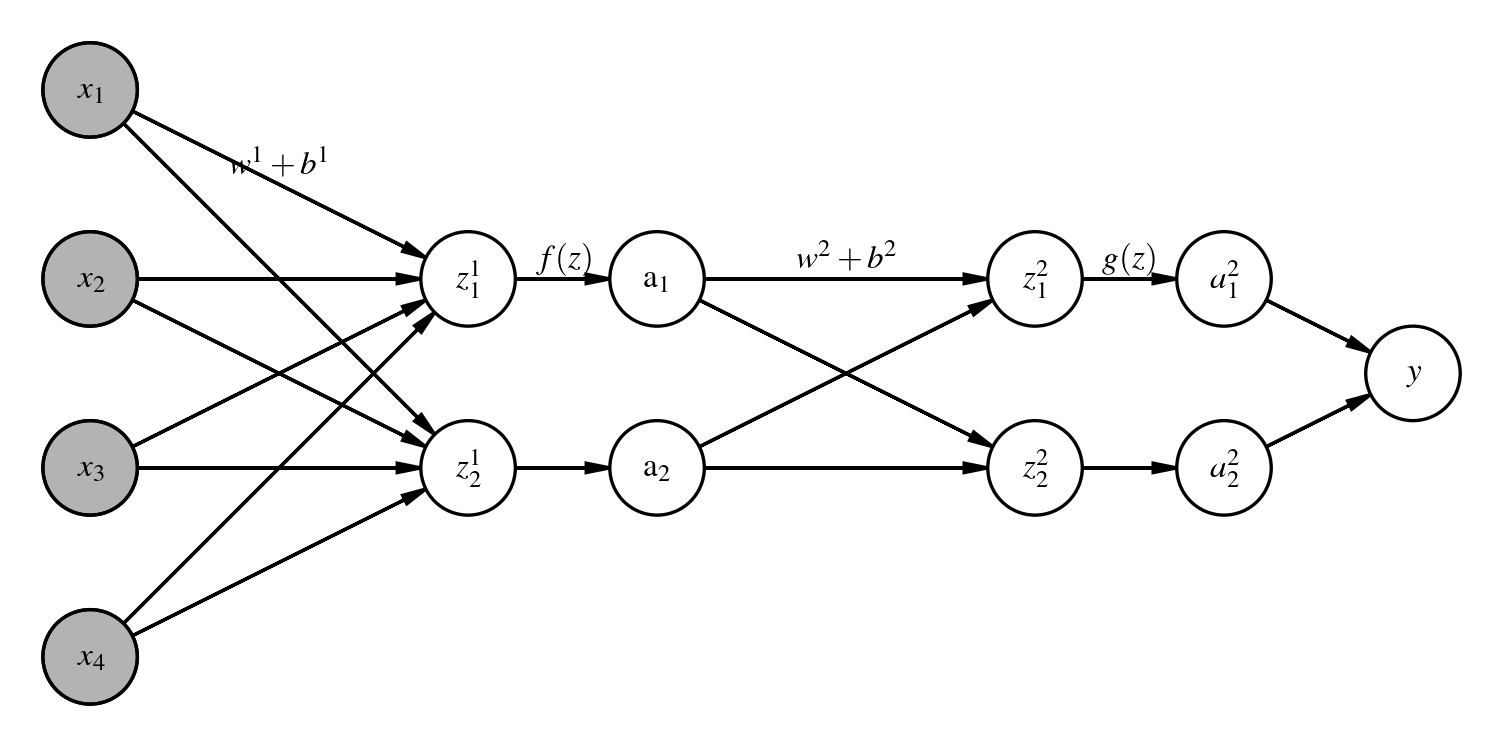

In [5]:
pgm = daft.PGM(dpi=240)
pgm.add_node("x1", r"$x_{1}$", 0, 3, observed=True)
pgm.add_node("x2", r"$x_{2}$", 0, 2, observed=True)
pgm.add_node("x3", r"$x_{3}$", 0, 1, observed=True)
pgm.add_node("x4", r"$x_{4}$", 0, 0, observed=True)
pgm.add_node("z1", r"$z_{1}^{1}$", 2, 2)
pgm.add_node("z2", r"$z_{2}^{1}$", 2, 1)
pgm.add_node("a1", r"a$_{1}$", 3, 2)
pgm.add_node("a2", r"a$_{2}$", 3, 1)
pgm.add_node("z3", r"$z_{1}^{2}$", 5, 2)
pgm.add_node("z4", r"$z_{2}^{2}$", 5, 1)
pgm.add_node("a3", r"$a_{1}^{2}$", 6, 2)
pgm.add_node("a4", r"$a_{2}^{2}$", 6, 1)
pgm.add_node("y", r"$y$", 7, 1.5)
pgm.add_edge("x1", "z1", label="$w^{1} + b^{1}$")
pgm.add_edge("x1", "z2")
pgm.add_edge("x2", "z1")
pgm.add_edge("x2", "z2")
pgm.add_edge("x3", "z1")
pgm.add_edge("x3", "z2")
pgm.add_edge("x4", "z1")
pgm.add_edge("x4", "z2")
pgm.add_edge("z1", "a1", label='$f(z)$')
pgm.add_edge("z2", "a2")
pgm.add_edge("a1", "z3", label="$w^{2} + b^{2}$")
pgm.add_edge("a1", "z4")
pgm.add_edge("a2", "z3")
pgm.add_edge("a2", "z4")
pgm.add_edge("z3", "a3", label='$g(z)$')
pgm.add_edge("z4", "a4")
pgm.add_edge("a3", "y")
pgm.add_edge("a4", "y")

pgm.render();

Here, $x = [x_{1}, x_{2}, x_{3}, x_{4}]$ is the input data, where each $x_{n}$ is a feature or label. This layer constitutes the layer $=0$ or ``input layer'';

We then have the first layer, constituted by the $z^{1} = [z^{1}_{1},z^{1}_{2}]$ neurons. Here each input label an each neuron is connected via some weight $w^{1}$ and some bias $b^{1}$. In this sense, $z^{1} = w^{1} @ x + b^{1}$.

After this comes the magic. The transformation from $z^{1}$ to $a^{1}$ is what makes NNs so useful. This is because the function $f(z)$ is called an activation function, and essentially serves as a transformer that takes something that is linear (i.e., $z^{1} = w^{1} @ x + b^{1}$) and turns it into something non-linear ($a^{1} = f(z^{1})$). The activation function can take on many forms, but some of the most used in the literature are the ReLU, sigmoid, and tanh functions (check wikipeadia out to learn more about these!).

The second layer is then the same as before, but now $z^{2} = w^{2} @ a^{1} + b^{2}$, and $a^{2} = g(z^{2})$. The activation function can be the same between different layers, or can be different. This is another reason why NNs are so flexible.

Lastly, you have the output $y$, which is the predictions of the model.

# How do NNs work?

I won't go into the deep weeds of how NNs work here. However, just for completeness, let's quickly discuss the steps the NN takes to optimise the model.

In essence, a NN takes the following steps:

1) Take some input (training) data ($x$), propagate it through via the layers (and neurons) to make some predicted guess of the desired outputs ($y$). This step is known as ``forward propagation''.

2) Determine how well the model performs based on the predicted values (given the weights and biases) compared to some training data. For example, train on a stars magnitude and temperature values to predict stellar type, and then compare the result to the known stellar type for the training stars. This can be done using some ``cost function''.

3) Feed this information back through the NN via assessing how the gradient of the cost function changes with respect to each of the model parameters (i.e., the weights and biases) and update the model parameters accordingly to reduce the value of the loss in the cost function. In more detail, this requires computing the gradient of the cost function wrt each model parameter, and then estimating the new value of the model parameters by taking the old value and subtracting the gradient $\textbf{times}$ some learning rate (usually 0.001).

4) Repeat steps 1-3 until for some number of iterations until you are happy with the desired predictors.



# Application to stellar classification 

Now that we have an idea of how NNs work in practice, lets build a 2-layer NN from scratch in JAX to predict stellar types from GALAH DR3 stellar parameters!

# Load and clean the data

In [6]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Projects/blog-posts/GALAHDR3_mags.csv'
data = pd.read_csv(path, index_col=False)

data

,dr3_source_id,teff,logg,fe_h,Li_fe,O_fe,Na_fe,Mg_fe,Al_fe,Si_fe,Ce_fe,j_m,h_m,ks_m,phot_g_mean_mag,bp_rp,r_med_geo
0,4.667369e+18,4553.3545,4.714953,-0.335019,-0.183756,1.214647,0.145268,-0.088498,0.467331,NaN,NaN,11.396,10.728,10.607,13.398778,1.716056,142.725810
1,4.667363e+18,3622.7446,4.691505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.060,10.425,10.255,13.397106,2.061252,95.959564
2,4.667325e+18,4852.4756,2.466885,-1.170157,1.070449,0.759033,-0.091090,0.107714,0.526840,0.335639,0.911001,11.981,11.468,11.374,13.442710,1.110548,3443.771700
3,4.667336e+18,5588.5005,3.999357,0.052395,0.534573,-0.019165,0.043523,0.086088,0.244746,-0.066913,NaN,12.135,11.760,11.710,13.330181,0.920680,798.638200
4,4.667324e+18,5709.5030,4.181905,-0.013732,1.037844,-0.030804,-0.067560,0.064595,-0.080545,-0.143940,NaN,11.248,10.883,10.822,12.330023,0.862075,411.515840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588566,6.003345e+18,4531.2153,2.410332,-0.293808,NaN,0.356744,0.023999,0.149684,0.383338,0.147312,-0.162081,7.189,6.621,6.438,8.893404,1.323564,351.244500
588567,6.000435e+18,6059.4995,3.519315,-0.045074,1.365148,0.193027,0.020073,-0.112607,-0.133977,-0.014719,NaN,10.465,10.209,10.139,11.602286,0.861840,853.888500
588568,6.000422e+18,4132.9727,0.959392,-1.003942,NaN,NaN,-0.166336,0.087043,-0.096362,0.091532,-0.855644,8.327,7.558,7.364,10.577829,1.804321,2575.376000
588569,6.000421e+18,4776.9272,2.420797,0.007314,NaN,0.196151,0.150166,-0.029941,0.186801,-0.005100,-0.134269,9.502,8.971,8.810,11.224582,1.348730,1433.930000


As we can see from the data frame the GALAH DR3 data is comprised of 588,571 stars, each of which has 9 properties: [id, temperature, surface gravity, metallicity, J/H/Ks magnitudes from 2MASS, $Gaia$ $G$ band magnitude, and $Gaia$ $B_{p}-R_{p}$ colour]

We will use all minus the id and the distance (r_med_geo) for training the NN. However, first we must remove bad data

In [7]:
mask = (data['teff']<8000)&(data['teff']>3000)&(data['logg']>0)&(data['logg']<6)&(np.abs(data['fe_h'])<2)&\
    (np.abs(data['j_m'])<50)&(np.abs(data['h_m'])<50)&(np.abs(data['ks_m'])<50)&\
    (np.abs(data['phot_g_mean_mag'])<50)&(np.abs(data['bp_rp'])<50)&(data['r_med_geo']<5000)&(data['r_med_geo']>500)&\
    (~np.isnan(data['teff']))&(~np.isnan(data['logg']))&(~np.isnan(data['fe_h']))&(~np.isnan(data['j_m']))&\
    (~np.isnan(data['j_m']))&(~np.isnan(data['h_m']))&(~np.isnan(data['ks_m']))&\
    (~np.isnan(data['phot_g_mean_mag']))&(~np.isnan(data['bp_rp']))&(~np.isnan(data['Li_fe']))&\
    (~np.isnan(data['O_fe']))&(~np.isnan(data['Na_fe']))&(~np.isnan(data['Mg_fe']))&\
    (~np.isnan(data['Al_fe']))&(~np.isnan(data['Si_fe']))&(~np.isnan(data['Ce_fe']))
    
print('There are '+str(len(data[mask]))+' stars after the masking')

There are 122213 stars after the masking


Note that we also only picked stars within 500 pc and 5 kiloparsec from us

Let's check the Kiel diagram to see our sample

Text(7700, 4.7, 'Main sequence')

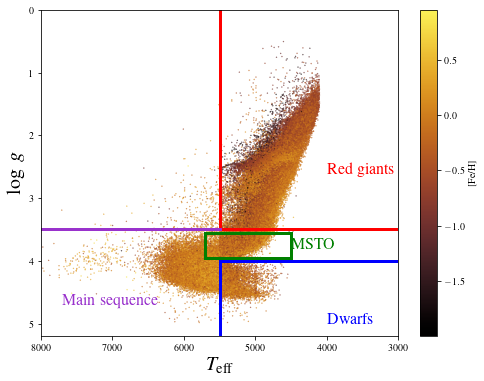

In [8]:
plt.figure(figsize=(8,6))

plt.scatter(data['teff'][mask], data['logg'][mask],c=data['fe_h'][mask],s=0.1,cmap=cm.amber)
plt.colorbar(label='[Fe/H]')
plt.xlim(8e3,3e3)
plt.ylim(5.2,0)
plt.xlabel('$T_{\mathrm{eff}}$',fontsize=20)
plt.ylabel('$\log~g$',fontsize=20)
plt.plot([5500, 3000], [3.5,3.5], c='r',lw=3)
plt.plot([5500, 5500], [3.5,0], c='r',lw=3)
plt.text(4000,2.6, 'Red giants', fontsize=16, color='r')
plt.plot([5500, 3000], [4.,4.], c='b',lw=3)
plt.plot([5500, 5500], [5.2,4.], c='b',lw=3)
plt.text(4000,5, 'Dwarfs', fontsize=16, color='b')
plt.plot([5700, 5700], [3.95,3.55], c='g',lw=3)
plt.plot([4500, 4500], [3.95,3.55], c='g',lw=3)
plt.plot([5700, 4500], [3.55,3.55], c='g',lw=3)
plt.plot([5700, 4500], [3.95,3.95], c='g',lw=3)
plt.text(4500,3.8, 'MSTO', fontsize=16, color='g')
plt.plot([8000, 5500], [3.5,3.5], c='darkorchid',lw=3)
plt.text(7700,4.7, 'Main sequence', fontsize=16, color='darkorchid')


In this diagram, I have highlighted (roughly) by eye where giant/dwarf/main-sequence/main-sequence turn off stars sit. However, since we have no information of this in the input data, we need to first create a script to label each star by these four categories

In [9]:
mask_giants = (data['teff'][mask]<5500)&(data['logg'][mask]<3.5)

mask_dwarfs = (data['teff'][mask]<5500)&(data['logg'][mask]>4.)

mask_msto = (data['teff'][mask]<5700)&(data['logg'][mask]>3.5)&(data['logg'][mask]<4)

mask_ms = (data['teff'][mask]<8000)&(data['teff'][mask]>5500)&(data['logg'][mask]>3.5)&~mask_msto

print('There are '+str(round(len(data[mask][mask_giants])/len(data[mask]),2))+' % giant stars')
print('There are '+str(round(len(data[mask][mask_dwarfs])/len(data[mask]),2))+' % dwarf stars')
print('There are '+str(round(len(data[mask][mask_msto])/len(data[mask]),2))+' % MSTO stars')
print('There are '+str(round(len(data[mask][mask_ms])/len(data[mask]),2))+' % MS stars')
print('There are '+str(len(data[mask]))+' stars in the sample')

There are 0.62 % giant stars
There are 0.07 % dwarf stars
There are 0.14 % MSTO stars
There are 0.17 % MS stars
There are 122213 stars in the sample


As we can see, the majority of the stars in our sample are giant stars. For example, the dwarf star sample is hugely under-represented. Thus, we will augment the data in the dwarf and MSTO, MS sets to make it a more levelled data-set. This process is known as (oviously) data-augmentation

In [10]:
frames = [data[mask][mask_dwarfs],data[mask][mask_dwarfs],data[mask][mask_dwarfs],data[mask][mask_dwarfs],data[mask][mask_dwarfs],data[mask][mask_dwarfs],data[mask][mask_dwarfs],\
         data[mask][mask_msto],data[mask][mask_msto],data[mask][mask_msto],\
         data[mask][mask_ms],data[mask][mask_ms],\
         data[mask]]

cdata = pd.concat(frames)

cmask_giants = (cdata['teff']<5500)&(cdata['logg']<3.5)

cmask_dwarfs = (cdata['teff']<5500)&(cdata['logg']>4.)

cmask_msto = (cdata['teff']<5700)&(cdata['logg']>3.5)&(cdata['logg']<4)

cmask_ms = (cdata['teff']<8000)&(cdata['teff']>5500)&(cdata['logg']>3.5)&~cmask_msto

print('There are '+str(round(len(cdata[cmask_giants])/len(cdata),2))+' % giant stars')
print('There are '+str(round(len(cdata[cmask_dwarfs])/len(cdata),2))+' % dwarf stars')
print('There are '+str(round(len(cdata[cmask_msto])/len(cdata),2))+' % MSTO stars')
print('There are '+str(round(len(cdata[cmask_ms])/len(cdata),2))+' % MS stars')


There are 0.28 % giant stars
There are 0.23 % dwarf stars
There are 0.26 % MSTO stars
There are 0.23 % MS stars


In [11]:
cdata

,dr3_source_id,teff,logg,fe_h,Li_fe,O_fe,Na_fe,Mg_fe,Al_fe,Si_fe,Ce_fe,j_m,h_m,ks_m,phot_g_mean_mag,bp_rp,r_med_geo
103,4.667234e+18,5481.9040,4.349805,-0.014216,0.768233,0.578946,0.019878,0.170615,0.250237,0.119844,1.280983,12.268,11.923,11.845,13.438139,0.907482,513.60270
105,4.667273e+18,5392.5215,4.285367,-0.130147,0.545835,0.365300,-0.014759,0.043349,0.124867,-0.029287,0.798054,12.263,11.879,11.754,13.546371,0.999254,516.83270
125,4.670238e+18,5487.9043,4.308903,0.126606,0.448995,0.274336,-0.015631,0.001868,0.179997,0.085119,0.628141,12.401,12.016,11.977,13.560228,0.934917,589.26570
395,4.775827e+18,5299.8480,4.280232,0.021641,0.686249,-0.206657,-0.041113,0.035003,0.213614,0.113304,0.992972,12.494,12.074,11.991,13.704469,0.974624,591.13434
448,4.775000e+18,5381.6953,4.198349,0.045960,0.337535,0.161573,0.073150,-0.014335,0.066212,-0.053257,0.439909,12.511,12.158,12.046,13.663292,0.928714,661.65940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588553,6.000446e+18,4234.7530,1.791848,-0.133460,-0.823269,0.420537,-0.061983,-0.237010,0.183282,0.125617,-0.163644,8.428,7.750,7.570,10.372470,1.543877,1187.91250
588555,6.003440e+18,4784.1855,2.494993,-0.125307,-0.175138,0.094137,-0.043951,0.076972,0.174168,0.036786,-0.238116,9.192,8.604,8.497,10.913098,1.336423,948.61300
588561,6.000435e+18,4626.5635,2.614739,-0.317191,-0.359884,0.470059,-0.087148,0.018610,0.244744,0.119682,-0.108184,9.704,9.162,9.036,11.488928,1.339677,852.24530
588564,6.000436e+18,5174.4390,3.017976,-0.189148,0.537736,-0.111856,0.018141,-0.040608,0.041941,-0.103020,-0.269703,8.337,7.903,7.808,9.667542,1.030191,526.45233


# Make sure you shuffle the array

In [12]:
cd_np = np.array(cdata)
shuffled_cd = np.take(cd_np,np.random.permutation(cd_np.shape[0]),axis=0)

In [13]:
shuffled_cd = pd.DataFrame(shuffled_cd, columns= cdata.columns)

In [14]:
shuffled_cd

,dr3_source_id,teff,logg,fe_h,Li_fe,O_fe,Na_fe,Mg_fe,Al_fe,Si_fe,Ce_fe,j_m,h_m,ks_m,phot_g_mean_mag,bp_rp,r_med_geo
0,6.460258e+18,4678.0776,2.080704,-0.413364,-0.141466,0.189639,0.350425,0.350010,0.429004,0.173244,-0.552670,10.624,9.981,9.859,12.407076,1.399663,2722.91500
1,5.796988e+18,6130.3164,3.967329,-0.260973,1.382031,0.268712,0.188829,0.031922,0.129361,0.144322,0.498821,11.979,11.701,11.656,12.990717,0.767701,767.12640
2,6.672217e+18,4980.5923,2.478778,-1.158654,1.176225,0.499050,0.006591,0.254160,0.222678,0.368676,0.198565,12.259,11.771,11.696,13.690955,1.092950,3159.94680
3,6.241914e+18,5411.9960,3.811759,-0.273492,0.646313,0.473195,0.051007,0.427955,0.240695,0.105618,0.378992,14.114,13.684,13.622,15.463282,1.049027,2082.41820
4,6.046826e+18,4892.6880,2.205092,-0.406674,0.183283,0.270393,0.426440,0.293052,0.308328,0.202578,-0.070310,11.609,11.016,10.923,13.454868,1.399144,4089.69560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273110,6.153557e+18,5800.0250,4.118150,-0.000047,1.011366,-0.003278,0.141915,-0.034573,0.059878,-0.051572,0.235090,12.033,11.733,11.647,13.138252,0.847286,659.98820
273111,6.750517e+18,5354.5464,3.809588,0.063947,0.680177,0.023985,0.097010,-0.028763,0.222228,0.081084,-0.009380,11.950,11.573,11.470,13.313297,1.053867,887.96875
273112,6.111279e+18,5696.3770,3.687414,0.247560,0.416144,0.073980,0.189790,0.006798,0.096508,0.071579,0.026557,12.217,11.898,11.843,13.367022,0.906711,1359.64710
273113,4.422704e+18,5426.7180,4.176108,0.187997,0.106207,-0.099600,0.056103,0.146878,0.166314,0.005542,0.083722,12.097,11.618,11.534,13.287828,1.033321,534.14026


In [15]:
cmask_giants = (shuffled_cd['teff']<5500)&(shuffled_cd['logg']<3.5)

cmask_dwarfs = (shuffled_cd['teff']<5500)&(shuffled_cd['logg']>4.)

cmask_msto = (shuffled_cd['teff']<5700)&(shuffled_cd['logg']>3.5)&(shuffled_cd['logg']<4)

cmask_ms = (shuffled_cd['teff']<8000)&(shuffled_cd['teff']>5500)&(shuffled_cd['logg']>3.5)&~cmask_msto

print('There are '+str(round(len(shuffled_cd[cmask_giants])/len(shuffled_cd),2))+' % giant stars')
print('There are '+str(round(len(shuffled_cd[cmask_dwarfs])/len(shuffled_cd),2))+' % dwarf stars')
print('There are '+str(round(len(shuffled_cd[cmask_msto])/len(shuffled_cd),2))+' % MSTO stars')
print('There are '+str(round(len(shuffled_cd[cmask_ms])/len(shuffled_cd),2))+' % MS stars')

There are 0.28 % giant stars
There are 0.23 % dwarf stars
There are 0.26 % MSTO stars
There are 0.23 % MS stars


In [16]:
star_type = np.zeros((len(shuffled_cd)))
star_type[cmask_giants] = 0
star_type[cmask_dwarfs] = 1
star_type[cmask_msto] = 2
star_type[cmask_ms] = 3


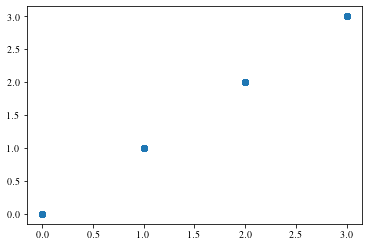

In [17]:
plt.scatter(star_type,star_type)

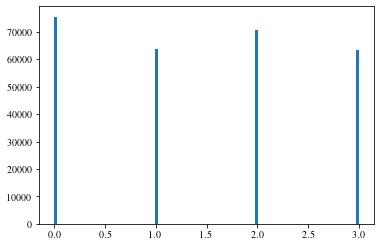

0.27626091573146844
0.23281035461252586
0.25832341687567506
0.23260531278033064


In [18]:
plt.hist(star_type,100)
plt.show()

print(len(star_type[np.where(star_type==0)])/len(star_type))
print(len(star_type[np.where(star_type==1)])/len(star_type))
print(len(star_type[np.where(star_type==2)])/len(star_type))
print(len(star_type[np.where(star_type==3)])/len(star_type))

Now that we have our output labels to compare against, lets remove the columns we don't want in our data

In [19]:
listd = ['dr3_source_id', 'r_med_geo', 'teff', 'logg']
cdat = shuffled_cd.drop(listd,axis=1)
cdat

,fe_h,Li_fe,O_fe,Na_fe,Mg_fe,Al_fe,Si_fe,Ce_fe,j_m,h_m,ks_m,phot_g_mean_mag,bp_rp
0,-0.413364,-0.141466,0.189639,0.350425,0.350010,0.429004,0.173244,-0.552670,10.624,9.981,9.859,12.407076,1.399663
1,-0.260973,1.382031,0.268712,0.188829,0.031922,0.129361,0.144322,0.498821,11.979,11.701,11.656,12.990717,0.767701
2,-1.158654,1.176225,0.499050,0.006591,0.254160,0.222678,0.368676,0.198565,12.259,11.771,11.696,13.690955,1.092950
3,-0.273492,0.646313,0.473195,0.051007,0.427955,0.240695,0.105618,0.378992,14.114,13.684,13.622,15.463282,1.049027
4,-0.406674,0.183283,0.270393,0.426440,0.293052,0.308328,0.202578,-0.070310,11.609,11.016,10.923,13.454868,1.399144
...,...,...,...,...,...,...,...,...,...,...,...,...,...
273110,-0.000047,1.011366,-0.003278,0.141915,-0.034573,0.059878,-0.051572,0.235090,12.033,11.733,11.647,13.138252,0.847286
273111,0.063947,0.680177,0.023985,0.097010,-0.028763,0.222228,0.081084,-0.009380,11.950,11.573,11.470,13.313297,1.053867
273112,0.247560,0.416144,0.073980,0.189790,0.006798,0.096508,0.071579,0.026557,12.217,11.898,11.843,13.367022,0.906711
273113,0.187997,0.106207,-0.099600,0.056103,0.146878,0.166314,0.005542,0.083722,12.097,11.618,11.534,13.287828,1.033321


In [20]:
# we will convert it into a numpy matrix to be able to manipulate it
dat = np.array(cdat)
star_t = star_type
dat.shape, star_t.shape

((273115, 13), (273115,))

# Scaling the data and splitting into training and test data

In [21]:
# get pivots and scales
qs = jnp.nanpercentile(dat.T, jnp.array([2.5, 50., 97.5]), axis=1)
pivots = qs[1]
scales = (qs[2] - qs[0])/4. # 4 is because 95 percentile range is 4 sigma (-2*sigma to +2*sigma)
dat.shape, pivots.shape, scales.shape
dat = ((dat - pivots) / scales)
dat.shape

(273115, 13)

In [22]:
star_t.shape

(273115,)

In [23]:
percen = 0.5 # 80% of the sample
end = len(dat)*percen
X_train = dat[:round(end)].T
Y_train = star_t[:round(end)].T

X_test = dat[round(end):].T
Y_test = star_t[round(end):].T

print('Train data shape X: '+str(X_train.shape)+'; Train data shape Y: '+str(Y_train.shape))
print('Test data shape X: '+str(X_test.shape)+'; Test data shape Y: '+str(Y_test.shape))

Train data shape X: (13, 136558); Train data shape Y: (136558,)
Test data shape X: (13, 136557); Test data shape Y: (136557,)


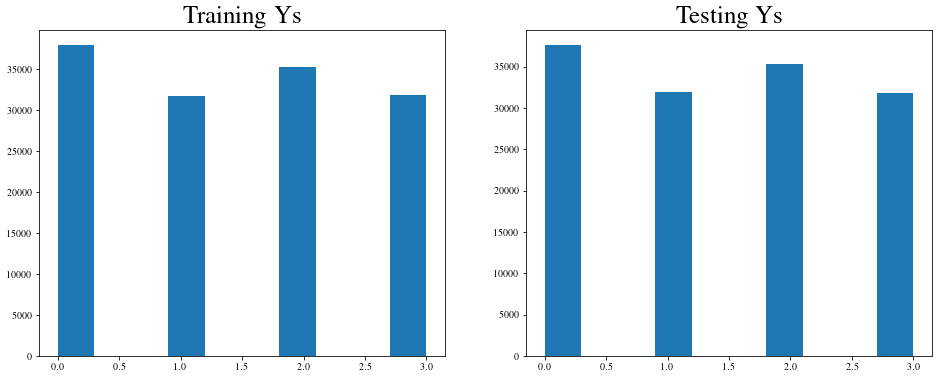

In [24]:
plt.figure(figsize=(16,6), facecolor='white')

plt.subplot(1,2,1)
plt.title('Training Ys', fontsize=25)
plt.hist(Y_train)
# plt.ylim(0,80000)

plt.subplot(1,2,2)
plt.title('Testing Ys', fontsize=25)
plt.hist(Y_test)
# plt.ylim(0,80000)

plt.show()

# building a 2-layer NN

Let's now write the necessary code. This will be the backbone of the model. 

We will create a 2-layer neural net with 10 neurons in the hidden (1st) layer, and we will use a ReLU as our activation function between layer 1 and 2 

In [58]:
###############################
# initialisation of parameters
############################### 

def initialise_params(X_train, K1 = 10, K2 = 4):
    
    input_size = X_train.shape[0] # number of input dimensions (labels)
    
    W1 = np.random.randn(K1, input_size)*0.1
    b1 = jnp.zeros((K1, 1)) 
    W2 = np.random.randn(K2, K1)*0.1 
    b2 = jnp.zeros((K2, 1))  
    
    return W1, b1, W2, b2
    
###############################
# activation functions
############################### 

def ReLU(Z):
    return jnp.maximum(0, Z)

def softmax(Z):
    z = Z.T
    exp = jnp.exp(z)
    out = exp.T/jnp.sum(exp,axis=1)
    return out.T
    
def sigmoid(Z):
    return 1./(1.+jnp.exp(-Z))

def tanh(Z):
    return jnp.tanh(Z)

###############################
# forward propagation
############################### 

def forward_prop(X, W1, b1, W2, b2):
    
    # first layer
    Z1 = W1@X + b1
    
    # first layer activation
    A1 = ReLU(Z1)

    # second layer
    Z2 = W2@A1 + b2
    
    # Second layer activation    
    A2 = softmax(Z2)
    
    return A2

###############################
# cost function: MSE
############################### 

def cost_mse(Y, X, W1, b1, W2, b2, Lambda=0.2):
    
    # calculate the predicted value
    P = forward_prop(X, W1, b1, W2, b2)

    # one hot encode the outputs
    Y_test_one_hot = to_categorical(Y)[0]
            
    # estimate the loss
    resta = (P-Y_test_one_hot)**2
    loss = jnp.sum(resta)/Y.shape[0]

    return loss

###############################
# backward propagation
############################### 

def backward_prop(Y_train, X_train, W1, b1, W2, b2):

    # calculate the gradients
    grad_cost_mse_W1 = jax.grad(cost_mse, 2)
    grad_cost_mse_b1 = jax.grad(cost_mse, 3)
    grad_cost_mse_W2 = jax.grad(cost_mse, 4)
    grad_cost_mse_b2 = jax.grad(cost_mse, 5)
    
    grad_W1 = grad_cost_mse_W1(Y_train, X_train, W1, b1, W2, b2)
    grad_b1 = grad_cost_mse_b1(Y_train, X_train, W1, b1, W2, b2)
    grad_W2 = grad_cost_mse_W2(Y_train, X_train, W1, b1, W2, b2)
    grad_b2 = grad_cost_mse_b2(Y_train, X_train, W1, b1, W2, b2)
    
    return grad_W1, grad_b1, grad_W2, grad_b2
    

def update_params(W1, b1, W2, b2, grad_W1, grad_b1, grad_W2, grad_b2, lr = 0.05):

    W1_new = W1 - lr * grad_W1
    b1_new = b1 - lr * grad_b1
    W2_new = W2 - lr * grad_W2
    b2_new = b2 - lr * grad_b2
    
    return W1_new, b1_new, W2_new, b2_new


###############################
# epoch iteration code
############################### 

def grad_descent(X_train, Y_train, iterations, W1, b1, W2, b2, lr):
        
    loss = []
    W1_save = jnp.zeros((iterations, W1.shape[0], W1.shape[1]))
    b1_save = jnp.zeros((iterations, b1.shape[0], b1.shape[1]))
    W2_save = jnp.zeros((iterations, W2.shape[0], W2.shape[1]))
    b2_save = jnp.zeros((iterations, b2.shape[0], b2.shape[1]))

    # loop over the iterations and perform the fitting
    for indx, i in tqdm.tqdm_notebook(enumerate(range(iterations))):
        
        # estimate the predicted value given the initialised parameters
        prediction = forward_prop(X_train, W1, b1, W2, b2)

        # run backward propagation
        grad_W1, grad_b1, grad_W2, grad_b2 = backward_prop(Y_train, X_train, W1, b1, W2, b2)

        # update the weights and biases in the model
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, grad_W1, grad_b1, grad_W2, grad_b2, lr=lr)

        # store the values of the parameters in the chain
        W1_save = W1_save.at[indx].set(W1)
        b1_save = b1_save.at[indx].set(b1)
        W2_save = W2_save.at[indx].set(W2)
        b2_save = b2_save.at[indx].set(b2)

        # print the iteration and calculate the new loss value given the updated weights and biases
        loss.append(cost_mse(Y_train, X_train, W1, b1, W2, b2))
            
    return W1, b1, W2, b2, loss, W1_save, b1_save, W2_save, b2_save
        

# Training the model

In [59]:
# initialise the parameters
W1, b1, W2, b2 = initialise_params(X_train, K1=10, K2=4)

# estimate the loss from the initialised parameters
loss = cost_mse(Y_train, X_train, W1, b1, W2, b2)
print('Loss from initialised parameters: '+str(loss))

Loss from initialised parameters: 0.76503766


In [51]:
iterations = 100

# use a learning rate of 0.001
W1, b1, W2, b2, loss, W1_save, b1_save, W2_save, b2_save = \
                grad_descent(X_train, Y_train, iterations, W1, b1, W2, b2, 0.00001)

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_76154/2006362632.py:116: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for indx, i in tqdm.tqdm_notebook(enumerate(range(iterations))):


0it [00:00, ?it/s]

Text(0.5, 0, 'Iterations')

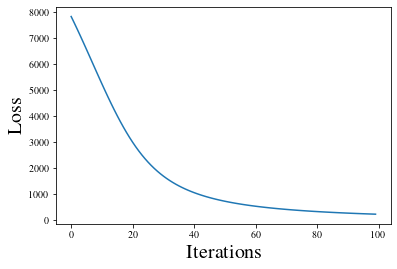

In [52]:
plt.plot(loss)
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Iterations', fontsize=20)


In [53]:
# print the last value of the loss
loss[-1]

Array(238.62599, dtype=float32)

# Test the model's accuracy

In [54]:
predictions = forward_prop(X_test, W1, b1, W2, b2)
pred = np.argmax(predictions,1)

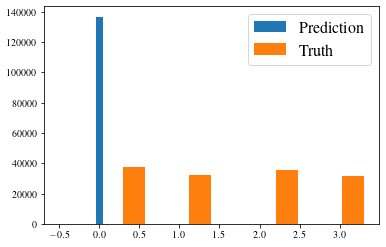

In [55]:
plt.hist(pred,11, label='Prediction')
plt.hist(Y_test+0.3,11, label='Truth')
plt.legend(loc='upper right', fontsize=16)
plt.show()

In [38]:
mask_correct = np.where(pred==Y_test.astype(int))

number_of_correct_classified_stars = len(pred[mask_correct])
total_number_of_stars = len(Y_test.astype(int))

acc = number_of_correct_classified_stars/total_number_of_stars*100
print('The model accurary is '+str(round(acc,3))+' %')

The model accurary is 17.727 %


In [ ]:
# teff_test = X_test[0,:]*scales[0] +pivots[0]
# logg_test = X_test[1,:]*scales[1] +pivots[1]

teff_test = data['teff'][mask][round(end):].T
logg_test = data['logg'][mask][round(end):].T


In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(teff_test, logg_test,c=pred,s=1,cmap='coolwarm')
plt.colorbar(label='[Fe/H]')
plt.xlim(8e3,3e3)
plt.ylim(5.2,0)
plt.xlabel('$T_{\mathrm{eff}}$',fontsize=20)
plt.ylabel('$\log~g$',fontsize=20)
plt.plot([8000, 3000], [3.5,3.5], c='k',lw=3)
# plt.plot([5500, 5500], [3.5,0], c='r',lw=3)
plt.text(4000,2.6, 'Red giants', fontsize=16, color='r')
# plt.plot([8000, 3000], [4.,4.], c='b',lw=3)
# plt.plot([5500, 5500], [5.2,4.], c='b',lw=3)
plt.text(4000,5, 'Dwarfs', fontsize=16, color='b')
# plt.plot([6000, 6000], [3.95,3.55], c='g',lw=3)
# plt.plot([4500, 4500], [3.95,3.55], c='g',lw=3)
# plt.plot([6000, 4500], [3.55,3.55], c='g',lw=3)
# plt.plot([6000, 4500], [3.95,3.95], c='g',lw=3)
# plt.text(4500,3.8, 'MSTO', fontsize=16, color='g')
# plt.plot([8000, 5500], [3.5,3.5], c='darkorchid',lw=3)
# plt.text(7700,4.7, 'Main sequence', fontsize=16, color='darkorchid')

# some thoughts

could extend this model to incorporate more classifications